<a href="https://colab.research.google.com/github/pursh2002/Machine-learning-with-team-sept-2019..-Dr-Purshottam/blob/master/Fashion_MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd

/root


In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [0]:
#!ls "/content/gdrive/My Drive/"

In [3]:
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvisionimport torch

ERROR: torch-0.4.1-{platform}-linux_x86_64.whl is not a valid wheel filename.


In [7]:
#!pip3 install torch torchvision

In [8]:
#!apt-get install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [4]:
import PIL
print(PIL.PILLOW_VERSION)

4.3.0


In [5]:
!pip install -q keras
import keras

Using TensorFlow backend.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from __future__ import print_function,division
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense , Reshape , Flatten, Dropout 
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam 
from keras.layers import BatchNormalization , Activation , ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
import sys 
import numpy as np 
import tensorflow as tf

In [8]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz


--2019-10-17 18:32:32--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.130
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.74.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M   100MB/s    in 0.3s    

2019-10-17 18:32:33 (100 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2019-10-17 18:32:36--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.174
Connecting to fashion-mnist.s3-website.eu-central-1.amazo

In [9]:
ls

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [10]:
!mkdir MNIST_Fashion
!cp *.gz MNIST_Fashion/
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_Fashion/")


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
#Training PArams
learning_rate = 0.0002
batch_size = 128
epochs = 100000

#Network params
image_dim = 784 #img sz is 28x28
gen_hidd_dim = 256
disc_hidd_dim  = 256
z_noise_dim = 100

def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev= 1./tf.sqrt(shape[0]/2.0))

In [0]:
weights = {
    "disc_H" : tf.Variable(xavier_init([image_dim, disc_hidd_dim])),
    "disc_final": tf.Variable(xavier_init([disc_hidd_dim,1])),
    "gen_H": tf.Variable(xavier_init([z_noise_dim, gen_hidd_dim])),
    "gen_final": tf.Variable(xavier_init([gen_hidd_dim, image_dim]))
}

bias = {
    "disc_H" : tf.Variable(xavier_init([disc_hidd_dim])),
    "disc_final": tf.Variable(xavier_init([1])),
    "gen_H": tf.Variable(xavier_init([gen_hidd_dim])),
    "gen_final": tf.Variable(xavier_init([image_dim]))
}

In [0]:
def Discriminator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["disc_H"]), bias["disc_H"]))
  final_layer = (tf.add(tf.matmul(hidden_layer, weights["disc_final"]), bias["disc_final"]))
  disc_output = tf.nn.sigmoid(final_layer)
  return final_layer, disc_output
  

In [0]:
#Generator NW
def Generator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["gen_H"]), bias["gen_H"]))
  final_layer = (tf.add(tf.matmul(hidden_layer, weights["gen_final"]), bias["gen_final"]))
  gen_output = tf.nn.sigmoid(final_layer)
  return gen_output

In [0]:
#define placeholders for external input

z_input = tf.placeholder(tf.float32, shape = [None, z_noise_dim], name = "input_noise")
x_input = tf.placeholder(tf.float32, shape = [None, image_dim], name = "real_noise")

In [0]:
# building the GEN NW
with tf.name_scope("Generator") as scope:
  output_Gen = Generator(z_input) #G(z)
 
 # Building the Disc NW
with tf.name_scope("Generator") as scope:
  real_output1_Disc, real_output_disc = Discriminator(x_input) #implements D(x)
  fake_output1_Disc, fake_output_disc = Discriminator(output_Gen) # implements D(G(x))

In [0]:
#first kind of loss
with tf.name_scope("Discriminator_Loss") as scope:
  Discriminator_Loss = -tf.reduce_mean(tf.log(real_output_disc+ 0.0001)+tf.log(1.- fake_output_disc+0.0001))
  
with tf.name_scope("Genetator_Loss") as scope:
  Generator_Loss = -tf.reduce_mean(tf.log(fake_output_disc+ 0.0001)) # due to max log(D(G(x)))

  # T-board summary
  
  Disc_loss_total = tf.summary.scalar("Disc_Total_loss", Discriminator_Loss)
  Gen_loss_total = tf.summary.scalar("Gen_loss", Generator_Loss)

In [19]:
#second kind of loss
with tf.name_scope("Discriminator_Loss") as scope:
  Disc_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = real_output1_Disc, labels = tf.ones_like(real_output1_Disc)))
  Disc_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_output1_Disc, labels = tf.zeros_like(fake_output1_Disc)))
  Discriminator_Loss = Disc_real_loss + Disc_fake_loss

  
with tf.name_scope("Genetator_Loss") as scope:
  Generator_Loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_output1_Disc, labels = tf.ones_like(fake_output1_Disc)))
  
  # Tensorboarf summary
  
Disc_loss_real_summary = tf.summary.scalar('Disc_loss_real', Disc_real_loss)
Disc_loss_fake_summary = tf.summary.scalar('Disc_loss_fake', Disc_fake_loss)
Disc_loss_summary = tf.summary.scalar('Disc_total_loss', Discriminator_Loss)

Disc_loss_total = tf.summary.merge([Disc_loss_real_summary, Disc_loss_fake_summary, Disc_loss_summary])
Gen_loss_total = tf.summary.scalar('Gen_loss', Generator_Loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Define the variables

Generator_var = [weights["gen_H"], weights["gen_final"], bias["gen_H"], bias["gen_final"]]
Discriminator_var = [weights["disc_H"], weights["disc_final"], bias["disc_H"], bias["disc_final"]]

#Define the optimizer
with tf.name_scope("Optimizer_Discriminator") as scope:
  Discriminator_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Discriminator_Loss, var_list = Discriminator_var)

with tf.name_scope("Optimizer_Generator") as scope:
  Generator_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Generator_Loss, var_list = Generator_var)
  

In [21]:
# Initialize the variables

init = tf.global_variables_initializer()
sess = tf.Session()

sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):
  x_batch, _ = mnist.train.next_batch(batch_size)
  
  #Generate noise to feed Discriminator
  z_noise = np.random.uniform(-1.,1.,size = [batch_size, z_noise_dim])
  _, Disc_loss_epoch = sess.run([Discriminator_optimize, Discriminator_Loss], feed_dict = {x_input:x_batch, z_input:z_noise})
  _, Gen_loss_epoch = sess.run([Generator_optimize, Generator_Loss], feed_dict = {z_input:z_noise})  
  
  #Running the Discriminator summary
  summary_Disc_loss = sess.run(Disc_loss_total, feed_dict = {x_input:x_batch, z_input:z_noise})
  # Adding the Discriminator summary
  writer.add_summary(summary_Disc_loss, epoch)
  
  #Running the Generator summary
  summary_Gen_loss = sess.run(Gen_loss_total, feed_dict = {z_input:z_noise})
  # Adding the Generator summary
  writer.add_summary(summary_Gen_loss, epoch)
  
  if epoch % 2000 == 0:
    print("Steps: {0}: Generator Loss: {1}, Discriminator Loss:{2}".format(epoch, Gen_loss_epoch, Disc_loss_epoch))
  
  

Steps: 0: Generator Loss: 2.1468400955200195, Discriminator Loss:2.1675078868865967
Steps: 2000: Generator Loss: 5.552006721496582, Discriminator Loss:0.019716497510671616
Steps: 4000: Generator Loss: 3.026190757751465, Discriminator Loss:0.20890338718891144
Steps: 6000: Generator Loss: 2.8123245239257812, Discriminator Loss:0.17218056321144104
Steps: 8000: Generator Loss: 2.3203835487365723, Discriminator Loss:0.3925536870956421
Steps: 10000: Generator Loss: 3.056786298751831, Discriminator Loss:0.42012229561805725
Steps: 12000: Generator Loss: 2.4531667232513428, Discriminator Loss:0.4281766414642334
Steps: 14000: Generator Loss: 2.379417896270752, Discriminator Loss:0.5095168352127075
Steps: 16000: Generator Loss: 2.6293997764587402, Discriminator Loss:0.363961398601532
Steps: 18000: Generator Loss: 2.661160945892334, Discriminator Loss:0.443276584148407
Steps: 20000: Generator Loss: 2.5992677211761475, Discriminator Loss:0.911555290222168
Steps: 22000: Generator Loss: 2.19162297248

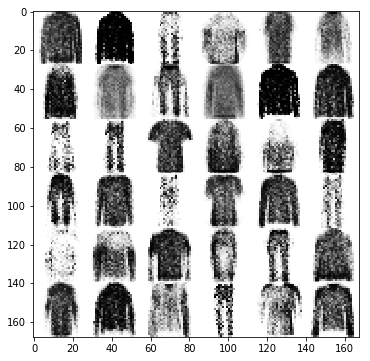

In [22]:
#Testing
# Generate images from noise, using the generator network

n = 6
canvas = np.empty((28*n, 28*n))
for i in range(n):
  #Noise input
  z_noise = np.random.uniform(-1.,1., size = [batch_size, z_noise_dim])
  # Generate image from noise
  g = sess.run(output_Gen, feed_dict = {z_input:z_noise})
  # Reverse colors for better display
  g=-1*(g-1)
  for j in range(n):
    #Draw the generated digits
    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = g[j].reshape([28, 28])
    
plt.figure(figsize = (n,n))
plt.imshow(canvas, origin = "upper", cmap = "gray")
plt.show()